In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
#@title Define your Paths (set yours)
#can find your path going on the "folder image" on the left,
#navigating your drive till the project folder, then selecting "copy path" in the "3dots menu" u.u
DIR_PATH = 'drive/MyDrive/Models/TimeVQVAE-main'
MODEL_PATH = 'drive/MyDrive/Models/TimeVQVAE-main' # 'timeVQVAE/TimeVQVAE-main'

In [ ]:
#@title Check Them
#just a check u're not messin up: u should see the list of your folder's descendants O.ò
print(os.listdir(os.path.join(os.getcwd(),DIR_PATH)))
print('-------')
print(os.listdir(os.path.join(os.getcwd(),MODEL_PATH)))

['.gitignore', 'evaluate.py', 'run_CAS.py', 'stage12_all_ucr.py', 'LICENSE', 'README.md', 'stage2.py', 'requirements.txt', 'MyExample_TimeVQVAE.ipynb', '.fig', 'generators', 'lightning_logs', 'encoder_decoders', 'datasets', 'experiments', 'preprocessing', 'configs', 'evaluation', '.google_colab', '__pycache__', 'utils', 'vector_quantization', 'saved_models', 'venv_timevqvae', 'results', 'stage1.py']
-------
['.gitignore', 'evaluate.py', 'run_CAS.py', 'stage12_all_ucr.py', 'LICENSE', 'README.md', 'stage2.py', 'requirements.txt', 'MyExample_TimeVQVAE.ipynb', '.fig', 'generators', 'lightning_logs', 'encoder_decoders', 'datasets', 'experiments', 'preprocessing', 'configs', 'evaluation', '.google_colab', '__pycache__', 'utils', 'vector_quantization', 'saved_models', 'venv_timevqvae', 'results', 'stage1.py']


In [ ]:
#@title Install HERE! (set yours)
#added wget in requirements.txt just before supervised_fcn because it downloads an older version instead
!pip install -r 'drive/MyDrive/Models/TimeVQVAE-main/requirements.txt'

#import subprocess
#import sys
#
#requirements_path = os.path.join(os.getcwd(),'requirements.txt')
#
#subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-r', requirements_path])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.8/825.8 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 36.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3

In [ ]:
#@title Import HERE!
import torch
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True
import matplotlib.pyplot as plt
import os

In [ ]:
#@title Add the Model folder to the Path to allow Imports
import sys
sys.path.append(os.path.join(os.getcwd(),MODEL_PATH))

In [ ]:
import numpy as np

print("My numpy version is: ", np.__version__)


My numpy version is:  1.25.2


# VQVAE

### Training With Kuka Dataset

In [ ]:
#@title Import stage1, stage2, evaluate
# Just putting the scripts from these modules in a notebook format
from stage1 import *
#from stage2 import *
#from evaluate import *
from utils import *
#dataset_names = ['FordA']
config = load_yaml_param_settings(os.path.join(MODEL_PATH, 'configs/config.yaml'))
gpu_device_idx = 0

In [ ]:
config['trainer_params']['input_length']

100

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
#from sklearn.utils.class_weight import compute_class_weight
from datasets.kuka_dataset.KukaDataset import KukaDataset
from tqdm import tqdm

dataset_name = 'KUKA'
TRAIN_DATA_PATH = os.path.join(MODEL_PATH,"datasets/kuka_dataset/normal")
TEST_DATA_PATH = os.path.join(MODEL_PATH,"datasets/kuka_dataset/collisions")

#import random
#onlyfiles = pd.read_csv(os.path.join(os.getcwd(),TRAIN_DATA_PATH))
## dropping columns...
##onlyfiles.drop(dropping_col1, axis=1, inplace=True)
#
##splitting train and val...
#grouped = list(onlyfiles.groupby("ChassisId_encoded"))
#random.shuffle(grouped)
#train_ratio = 0.8
#split_index = int(len(grouped) * train_ratio)
## ...or maybe not if u train for testing...
#train_groups = grouped #grouped[:split_index]
#validation_groups = grouped #grouped[split_index:]

categories = np.array(['Low', 'High']).reshape(-1, 1)
encoder = OneHotEncoder(dtype=np.float32)
encoder.fit(categories)

train_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, config=config, keep_faulty=False, risk_encoder=encoder, drop_default=True)
val_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=False, config=config, keep_faulty=True, drop_default=True,
                          columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
#test_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=True, config=config, columns_to_keep=train_dataset.kept_columns)

config['dataset']['in_channels'] = len(train_dataset.kept_columns) - len(train_dataset.header_columns)

reading data...
preprocessing ... 
windowing ts 1/4
windowing ts 2/4
windowing ts 3/4
windowing ts 4/4
files were read...
95419 (100, 55)
--- Train Dataset ---
df len is: 95419 window shape is: (100, 55)
reading anomalies...
start adding high risk
found the excel and loaded it...
reading data...
preprocessing ... 
windowing ts 1/2
windowing ts 2/2
files were read...
34077 (100, 55)
--- Train Dataset ---
df len is: 34077 window shape is: (100, 55)


In [ ]:
#t_list.shape, v_list.shape
config['dataset']['in_channels'] # yeah, it's fine for in channels to be less
#train_dataset.kept_columns, train_dataset.header_columns      # because dataset get item drops other columns
#print(val_dataset.targets[10000:10150])
#train_dataset.kuka_df[0]

55

In [ ]:
#@title stage1.py script
# input to model forward is a tensor (B, C, L) batch, feats, window_timestamp

batch_size = config['dataset']['batch_sizes']['stage1']

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, collate_fn = KukaDataset.padding_collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=1)#, collate_fn = KukaDataset.padding_collate_fn)
#test_data_loader =  DataLoader(test_dataset, batch_size=1)#, collate_fn = KukaDataset.padding_collate_fn)


In [ ]:
## ALTERNATIVE TRAINING
#project_name = 'TimeVQVAE-stage1'
#
## fit
#input_length = config['trainer_params']['input_length']
#train_exp = ExpVQVAE(input_length, config, len(train_data_loader.dataset))
#
#import torch.optim as optim
## Check for GPU availability and set device
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
## Send model to device
#train_exp.to(device)
## Initialize optimizer
#optimizer = optim.Adam(train_exp.parameters(), lr=.001)
## Initialize learning rate scheduler
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#num_epochs = config['trainer_params']['max_epochs']['stage1']
#
## Set the number of accumulation steps
#accumulation_steps = 1
#
#print_every = 100
#
## Training loop
#for epoch in range(num_epochs):
#    train_exp.train()
#    optimizer.zero_grad()
#
#    for batch_idx, data in enumerate(train_data_loader):
#        data = (data[0].to(device), data[1].to(device))
#
#        # Forward pass
#        recons_loss, vq_losses, perplexities = train_exp(data)
#        loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
#                recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
#                vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
#                recons_loss['perceptual']
#
#        # Backward pass and accumulate gradients
#        loss.backward()
#
#        # Update weights every accumulation_steps batches
#        if (batch_idx + 1) % accumulation_steps == 0:
#            optimizer.step()
#            optimizer.zero_grad()
#
#        # Print progress
#        if (batch_idx + 1) % print_every == 0:
#            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_data_loader)}], Loss: {loss.item():.4f}')
#
#    # Step the scheduler
#    scheduler.step()
#
#    # Validation loop (optional)
#    #train_exp.eval()
#    #val_loss = 0
#    #with torch.no_grad():
#    #    for data in val_data_loader:
#    #        data = (data[0].to(device), data[1].to(device))
#    #        recons_loss, vq_losses, perplexities = train_exp(data)
#    #        loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
#    #            recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
#    #            vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
#    #            recons_loss['perceptual']
#    #        val_loss += loss.item()
#    #val_loss /= len(val_data_loader)
#
## test
#print('closing...')
##wandb.finish()
#
#print('saving the models...')
#save_model({'encoder_l': train_exp.encoder_l,
#            'decoder_l': train_exp.decoder_l,
#            'vq_model_l': train_exp.vq_model_l,
#            'encoder_h': train_exp.encoder_h,
#            'decoder_h': train_exp.decoder_h,
#            'vq_model_h': train_exp.vq_model_h,
#            }, id=dataset_name)

In [ ]:
from experiments.exp_vq_vae import ExpVQVAE
exp_vqvae = ExpVQVAE(config['trainer_params']['input_length'], config, len(train_data_loader.dataset))

models_dir = 'saved_models'
#models_dir = 'saved_models_200ep'
#models_dir = 'saved_models_1000ep'
#models_dir = 'saved_models_1000ep_dcol1'

# load
fname = f'vq_model_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'vq_model_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.vq_model_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.encoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),MODEL_PATH), models_dir, fname)
exp_vqvae.decoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)

exp_vqvae.eval()

ExpVQVAE(
  (encoder_l): VQVAEEncoder(
    (encoder): Sequential(
      (0): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(110, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (1): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (2): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
# KEEP BATCH SIZE = 1 HERE, PLEASE
mapping = {0: 'Low', 1: 'High'}
all_losses = []
window_label_pos = config['trainer_params']['input_length'] - 1
for batch in tqdm(val_data_loader): #iterating through test ds with step B

    x , y = batch[0], batch[1]
    #x = x.to(gpu_device_idx) #comment if using the CPU

    recons_loss, vq_losses, perplexities = exp_vqvae.forward((x,))

    print('losses shapes', recons_loss['LF.time'].shape, recons_loss['HF.time'].shape,
          recons_loss['LF.timefreq'].shape,recons_loss['HF.timefreq'].shape,
          vq_losses['LF']['loss'].shape,vq_losses['HF']['loss'].shape,
          recons_loss['perceptual'].shape, type(perplexities))

    loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
            recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
            vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
            recons_loss['perceptual']
    #print(y.shape)
    #curr_label = mapping[torch.argmax(y[0, :, 0]).item()]
    curr_label_encoded = y[0, :, 0].unsqueeze(0).numpy()
    curr_label = encoder.inverse_transform(curr_label_encoded)[0, 0]

    all_losses.append((loss.detach().item(), curr_label))

100%|██████████| 34077/34077 [26:19<00:00, 21.57it/s]


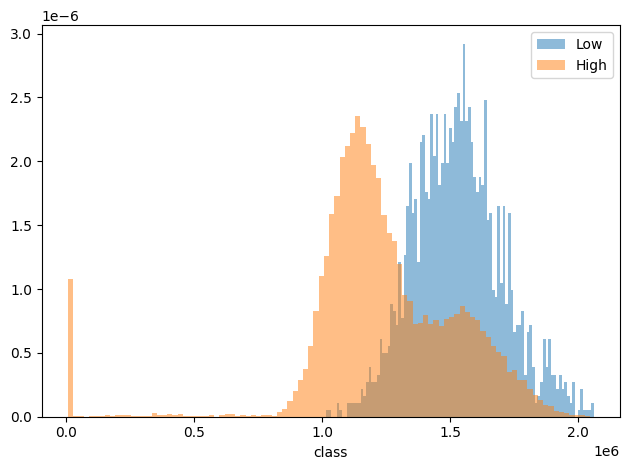

In [ ]:
bins=100
alpha=.5
max_x_axes = 6_000_000
plt.figure()
lows = [loss for loss, lb in all_losses if lb == 'Low' and loss <= max_x_axes]
highs = [loss for loss, lb in all_losses if lb == 'High' and loss <= max_x_axes]
#print(len(lows), len(highs))
plt.hist(lows, bins = bins, density = True, alpha = alpha, label = 'Low')
plt.hist(highs, bins = bins, density = True, alpha = alpha, label = 'High')
plt.xlabel('class')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
min([ls for ls, lb in all_losses]), max([ls for ls, lb in all_losses])

(6692.55859375, 1759951.125)

In [ ]:
from sklearn.linear_model import LogisticRegression

X = np.array([ls for ls, lb in all_losses]).reshape(-1, 1)

# Map labels to numeric values
label_map = {'Low': 0, 'High': 1}
y_numeric = np.array([label_map[lb] for ls, lb in all_losses])

# Logistic Regression model without regularization
logreg = LogisticRegression(penalty=None, solver='lbfgs')

# Fit the model
logreg.fit(X, y_numeric)

# Extract the coefficients
intercept = logreg.intercept_[0]
coef = logreg.coef_[0][0]

# Calculate the threshold where log-odds is 0
threshold = -intercept / coef

print(f"The threshold value where log-odds is 0 is: {threshold}")


The threshold value where log-odds is 0 is: -2.719903076591829e-07


In [ ]:
# KEEP BATCH SIZE = 1 HERE, PLEASE

window_label_pos = config['trainer_params']['input_length'] - 1
all_preds = []
for batch in test_data_loader: #iterating through test ds with step B
    x = batch[0]
    x = x.to(gpu_device_idx)
    preds = ["Low"]

    recons_loss, vq_losses, perplexities = exp_vqvae.forward((x,))

    loss = (recons_loss['LF.time'] + recons_loss['HF.time'] +
            recons_loss['LF.timefreq'] + recons_loss['HF.timefreq']) + \
            vq_losses['LF']['loss'] + vq_losses['HF']['loss'] + \
            recons_loss['perceptual']

    mask_gt_low = (loss > threshold)

    if mask_gt_low:
        preds= ["High"]

    all_preds.append(preds)

In [ ]:
all_preds

[['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High'],
 ['Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'Low'],
 ['Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'Medium',
  'High',
  'High',
  'High',

In [ ]:
df_pred = pd.DataFrame(data=np.ravel(all_preds), columns=['pred'])
df_pred.to_csv(os.path.join(DIR_PATH,'SampleSubmission/prediction.csv'), index=False)